
Decision Tree
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     33608
           1       0.75      0.67      0.71      1046

    accuracy                           0.98     34654
   macro avg       0.87      0.83      0.85     34654
weighted avg       0.98      0.98      0.98     34654

Top 10 Permutation Importances for Decision Tree (F1 Score):


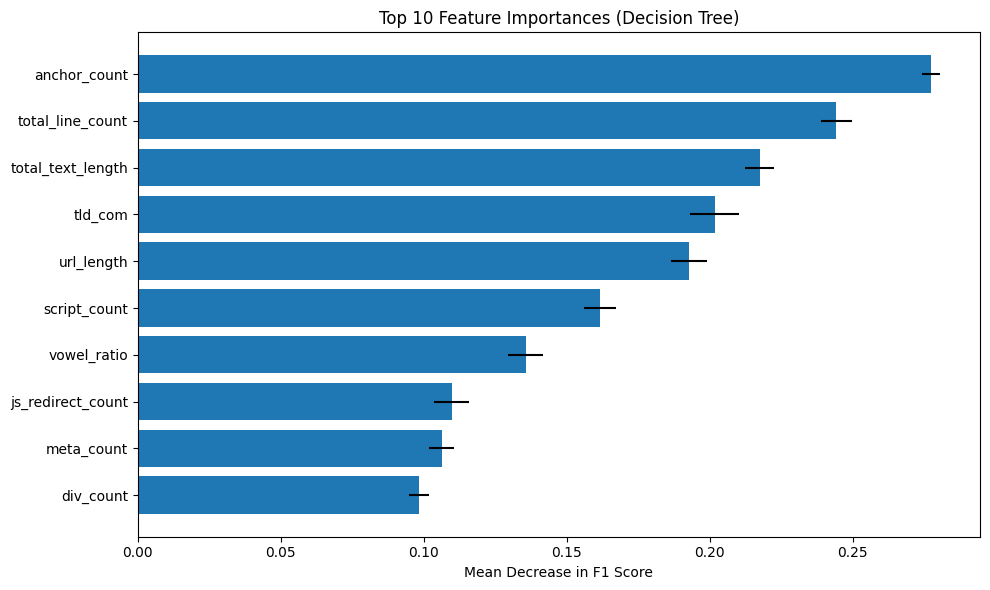

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Machine Learning Models
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.inspection import permutation_importance 

import time
from collections import Counter

df1 = pd.read_csv('url_features.csv').sort_values(by='url')
df2 = pd.read_csv('new_html_features.csv').sort_values(by='url')
df3 = pd.merge(df1, df2, on="url")

df3 = pd.get_dummies(df3, columns=['tld_type'], prefix='tld')
df3 = df3.rename(columns={'label_x': 'label'})

# 25% - 174,268
n_legit = 168040
n_phish = 5228


# 50% - 348,536
# n_legit = 337080
# n_phish = 10456

legit_df3 = df3[df3['label'] == 0]
phish_df3 = df3[df3['label'] == 1]

sampled_legit3 = legit_df3.sample(n=n_legit, random_state=42)
sampled_phish3 = phish_df3.sample(n=n_phish, random_state=42)

reduced_df3 = pd.concat([sampled_legit3, sampled_phish3]).sample(frac=1, random_state=42).reset_index(drop=True)

X3 = reduced_df3.drop(['url', 'label', 'label_y'], axis=1)
y3 = reduced_df3['label']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y3, test_size=0.2, random_state=42)


models = {
    "XGBoost": XGBClassifier(n_estimators= 281, max_depth= 14, learning_rate= 0.0888992418241481, subsample= 0.9134952932290352, colsample_bytree= 0.6533354924947662, gamma= 0.25380562179671745, random_state=42),
    "LightGBM": LGBMClassifier(num_leaves= 96, max_depth= 15, learning_rate= 0.16099354321038145, n_estimators= 292, subsample= 0.995245362847253, colsample_bytree= 0.883261087073046, min_child_samples= 25,random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators= 206, max_depth= 95, min_samples_split= 3, min_samples_leaf= 1, max_features= 'sqrt', random_state=42),
    "K-Nearest Neighbor": KNeighborsClassifier(n_neighbors= 18, weights= 'distance', p= 1, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(max_depth= 20, min_samples_split= 11, min_samples_leaf= 2, criterion='entropy', random_state=42)
}


for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train3, y_train3)
    pred = model.predict(X_test3)
    print(classification_report(y_test3, pred))

    print(f"Top 10 Permutation Importances for {name} (F1 Score):")
    result = permutation_importance(
        model, X_test3, y_test3, n_repeats=10, random_state=42, scoring='f1'
    )

    importances = result.importances_mean
    stds = result.importances_std
    sorted_idx = importances.argsort()[::-1][:10]

    top_features = X_test3.columns[sorted_idx]
    top_scores = importances[sorted_idx]
    top_stds = stds[sorted_idx]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], top_scores[::-1], xerr=top_stds[::-1])
    plt.xlabel("Mean Decrease in F1 Score")
    plt.title(f"Top 10 Feature Importances ({name})")
    plt.tight_layout()
    plt.show()
